In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
from scipy.stats import pearsonr, spearmanr
import anndata as ad
import seaborn as sns
import pickle

from main import *
from downstream import *

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from scipy.stats import ttest_rel
from decimal import Decimal

In [2]:
filenames = ["scg_results/Dataset3_knn_spage_tangram.h5ad",
             "scg_results/Dataset9_knn_spage_tangram.h5ad",
             "scg_results/Dataset11_knn_spage_tangram.h5ad",
             "scg_results/Dataset12_knn_spage_tangram.h5ad",
             "scg_results/Dataset13_knn_spage_tangram.h5ad",
             "scg_results/Dataset14_knn_spage_tangram.h5ad",
             "scg_results/Dataset15_knn_spage_tangram.h5ad",
             "scg_results/Dataset17_knn_spage_tangram.h5ad",
             ]

In [3]:
def dr_visualization (X, method):
    
    X_copy = X.copy()
    
    if method == "umap":
        reducer = umap.UMAP(random_state=444)
        X_viz = reducer.fit_transform(X_copy)
        
    elif method == "tsne":
        reducer = TSNE(init='pca', random_state=444)
        X_viz = reducer.fit_transform(X_copy)
        
    else:
        reducer = PCA(n_components=2)
        X_viz = reducer.fit_transform(X_copy)
        
    return (X_viz)

## Visualization metrics (comparison to measured data as ground truth)

In [ ]:
models = ["knn", "spage", "tangram"]

outputs_for_dynamicviz = {}


for fn in filenames:
    
    print(fn)
    
    # set up dict
    dataset_name = fn.split("/")[1].split("_")[0]
    outputs_for_dynamicviz[dataset_name] = {}
    for model in models:
        outputs_for_dynamicviz[dataset_name][model] = {}
        outputs_for_dynamicviz[dataset_name][model]['measured'] = {}
        outputs_for_dynamicviz[dataset_name][model]['baseline'] = {}
        outputs_for_dynamicviz[dataset_name][model]['sprite'] = {}
    
    # read in data
    adata = sc.read_h5ad(fn)
    
    # DR visualization
    for model in models:
        for dr_method in ['tsne', 'umap', 'pca']:

            # measured visualization
            measured_data = np.array(adata.X)
            measured_data = StandardScaler().fit_transform(measured_data)
            X_measured = dr_visualization(measured_data, dr_method)

            # get gene expression matrices
            add_baseline_imp = adata.obsm[model+"_predicted_expression_raw"].values.copy()
            add_baseline_imp = StandardScaler().fit_transform(add_baseline_imp)
            add_sprite_imp = adata.obsm["smoothed_reinforced_gene_joint_"+model+"_predicted_expression_raw"].values.copy()
            add_sprite_imp = StandardScaler().fit_transform(add_sprite_imp)

            # baseline visualization
            X_baseline = dr_visualization(add_baseline_imp, dr_method)

            # sprite visualization
            X_sprite = dr_visualization(add_sprite_imp, dr_method)

            # append data for dynamicviz
            outputs_for_dynamicviz[dataset_name][model]['ground_truth'] = measured_data
            outputs_for_dynamicviz[dataset_name][model]['measured'][dr_method] = X_measured
            outputs_for_dynamicviz[dataset_name][model]['baseline'][dr_method] = X_baseline
            outputs_for_dynamicviz[dataset_name][model]['sprite'][dr_method] = X_sprite

In [5]:
with open('visualization_data_for_dynamicviz_dict.pkl', 'wb') as handle:
    pickle.dump(outputs_for_dynamicviz, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Final Example Visualization Figure

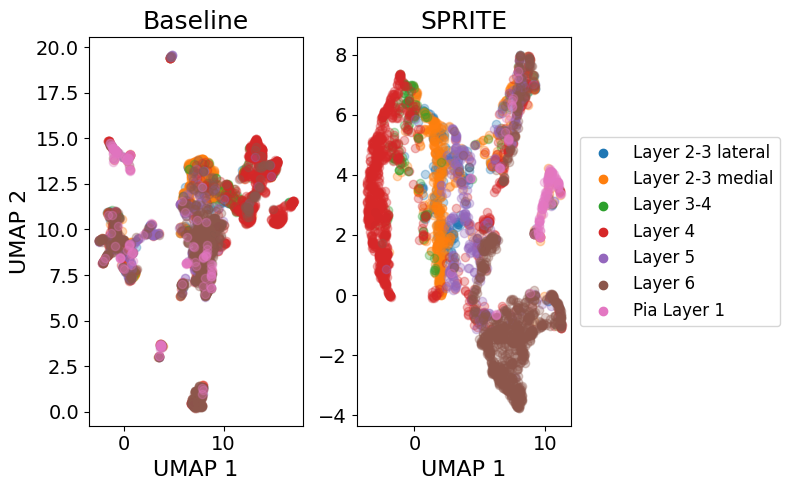

In [11]:
d = "Dataset15"
model = "knn"
label = "Region"
dr_method = "umap"

################################################
# read in data
adata = sc.read_h5ad(f'scg_results/{d}_knn_spage_tangram.h5ad')

# Get ground truth clustering
true_clusters = adata.obs[label]


X_orig = results_dict[d][model]['ground_truth']
X_measured_dr = results_dict[d][model]['measured'][dr_method]
X_base_dr = results_dict[d][model]['baseline'][dr_method]
X_sprite_dr = results_dict[d][model]['sprite'][dr_method]

fig, axs = plt.subplots(1,2,figsize=(8,5))
for lab in np.unique(true_clusters):
    axs[0].scatter(X_base_dr[true_clusters==lab,0],X_base_dr[true_clusters==lab,1],label=lab,alpha=0.3,
                               rasterized=True)
axs[0].set_title("Baseline", fontsize=18)
axs[0].set_ylabel("UMAP 2", fontsize=16)
axs[0].set_xlabel("UMAP 1", fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=14)


for lab in np.unique(true_clusters):
    axs[1].scatter(X_sprite_dr[true_clusters==lab,0],X_sprite_dr[true_clusters==lab,1],label=lab,alpha=0.3,
                               rasterized=True)
axs[1].set_title("SPRITE", fontsize=18)
axs[1].set_xlabel("UMAP 1", fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)

leg = axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.tight_layout()
plt.savefig(f'plots/sprite_visualization/{d}_{model}_{label}_{dr_method}.pdf', bbox_inches='tight', dpi=500)
plt.show()